# ** CPSC 8810 Deep Learning - Homework 1-2 **
---

## Introduction

The main objective of this assignments:
* Visualize the optimization process
* Observe gradient norm during training
* Observe what happen when gradient norm is almost zero


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
tf.__version__

'1.15.0'

## Data preparation and visualization
### Simulated Function
*f(x) = Sin(5πx)/(5πx)*              

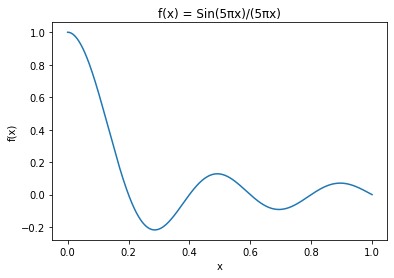

In [2]:
X = np.arange(0.0001,1,0.0001)
X_train = X.reshape(-1,1).astype(np.float32)
Y = np.sin(5*np.pi*X)/(5*np.pi*X)
Y_train = Y.reshape(-1,1).astype(np.float32)
plt.plot(X,Y)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('f(x) = Sin(5πx)/(5πx)');

## Placeholder for Input and Output

In [18]:
tf.reset_default_graph()
tf.random.set_random_seed(3)
np.random.seed(1)
input_x = tf.placeholder(tf.float32,shape=[None,1])
output_y = tf.placeholder(tf.float32,shape=[None,1])

### Network Architecture

In [19]:
# Model 1 neural network layers
h1 = tf.layers.dense(inputs=input_x, units=5, activation=tf.nn.relu, name='h1')   # hidden layer
h2 = tf.layers.dense(inputs=h1, units=10, activation=tf.nn.relu, name='h2')        # hidden layer
h3 = tf.layers.dense(inputs=h2, units=15, activation=tf.nn.relu, name='h3')        # hidden layer
h4 = tf.layers.dense(inputs=h3, units=10, activation=tf.nn.relu, name='h4')        # hidden layer
h5 = tf.layers.dense(inputs=h3, units=5, activation=tf.nn.relu, name='h5')        # hidden layer
output = tf.layers.dense(inputs=h4, units=1, name='output')                        # output layer

### Loss function and Optimizer Initialization

In [20]:
loss = tf.losses.mean_squared_error(output_y, output)   # compute cost
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

### Get weights variable from layers

In [21]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')
    return variable

w_h1 = tf.reshape(get_weights_variable('h1'),[1,-1])
w_h2 = tf.reshape(get_weights_variable('h2'),[1,-1])
w_h3 = tf.reshape(get_weights_variable('h3'),[1,-1])
w_h4 = tf.reshape(get_weights_variable('h4'),[1,-1])
w_h5 = tf.reshape(get_weights_variable('h5'),[1,-1])
w_out = tf.reshape(get_weights_variable('output'),[1,-1])
w_model = tf.concat([w_h1,w_h2,w_h3,w_h4,w_h5,w_out],axis=1)

### Gradient norm and Hessian Calculation

In [22]:
#grad = opt.compute_gradients(loss, weights_fc_out)[0]
grads = tf.gradients(loss, get_weights_variable('output'))[0]
grads_norm = tf.norm(grads)
print(grads)
print(grads_norm)

hessian = tf.reduce_sum(tf.hessians(loss, get_weights_variable('output'))[0], axis = 2)
print(hessian)

eigenvalue = tf.linalg.eigvalsh(hessian)
minimal_ratio = tf.divide(tf.count_nonzero(tf.greater(eigenvalue, 0.)),eigenvalue.shape[0])
print(minimal_ratio)

Tensor("gradients_1/output/MatMul_grad/MatMul_1:0", shape=(10, 1), dtype=float32)
Tensor("norm/Squeeze:0", shape=(), dtype=float32)
Tensor("Sum:0", shape=(10, 1, 1), dtype=float32)
Tensor("truediv:0", shape=(), dtype=float64)


In [41]:
def plot_pca(w_list):
    # Assume weights in weights_list are TensorFlow ops for 2-dim variables
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.    
    pca = PCA(n_components=2)
    fig = plt.figure(figsize = (8,8))
    plt.xlabel('Principal Component 1', fontsize = 15)
    plt.ylabel('Principal Component 2', fontsize = 15)
    plt.title('2 component PCA', fontsize = 20)
    #for i in range(w_list.shape[0]):
    principalComponents = pca.fit_transform(w_list)
    colors = plt.cm.magma(np.linspace(0,1,principalComponents.shape[0]))
    for i in range(principalComponents.shape[0]):
        plt.scatter(principalComponents[i,0], principalComponents[i,1],label=str(i*100)+'th Epoch',color=colors[i])
    plt.legend()
    plt.show()

### Training using normal loss function

In [35]:
sess = tf.Session() 
sess.run(tf.global_variables_initializer())         # initialize var in graph
EPOCH = 1000
w_m1_shape = w_model.get_shape().as_list()
total_weights_m1 = sess.run(w_model)
loss_list = []
grads_norm_list = []
min_ratio_list = []
for i in range(EPOCH):
    # train and net output
    _, l, pred, grad_norm,min_ratio = sess.run([train_op, loss, output,grads_norm,minimal_ratio], feed_dict={input_x: X_train, output_y: Y_train})
    loss_list.append(l)
    grads_norm_list.append(grad_norm)
    min_ratio_list.append(min_ratio)
    if ((i%100 == 0) and (i!=0)):
        weights_m1 = sess.run(w_model)
        total_weights_m1 = np.concatenate([total_weights_m1,weights_m1])
    if i%100 == 0:
        print("Epoch: ",i,"Loss: ",l)

Epoch:  0 Loss:  0.10360389
Epoch:  100 Loss:  0.035515197
Epoch:  200 Loss:  0.008390331
Epoch:  300 Loss:  0.0054154242
Epoch:  400 Loss:  0.0046510976
Epoch:  500 Loss:  0.004076313
Epoch:  600 Loss:  0.0034460905
Epoch:  700 Loss:  0.002893313
Epoch:  800 Loss:  0.0026423377
Epoch:  900 Loss:  0.002576532


### PCA Visualization

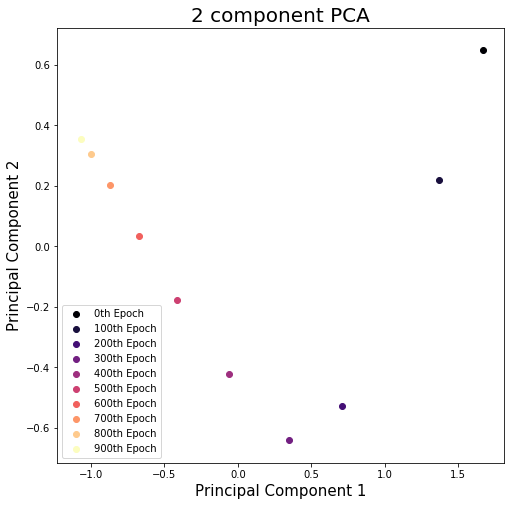

In [43]:
plot_pca(total_weights_m1)

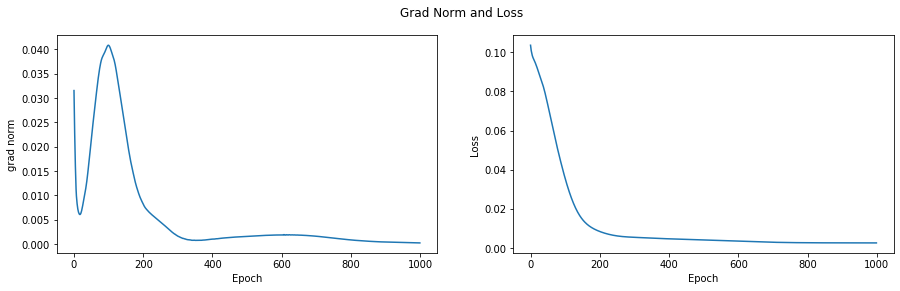

Text(0.5, 1.0, 'Minimal Ratio vs Loss')

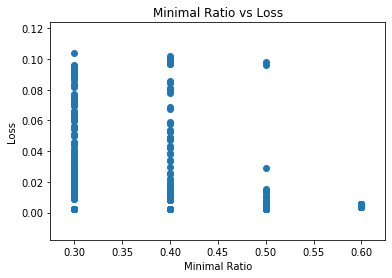

In [44]:
fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle('Grad Norm and Loss')
axs[0].plot(grads_norm_list)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('grad norm')
axs[1].plot(loss_list)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
plt.pause(0.1)
plt.scatter(min_ratio_list,loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss');
plt.title('Minimal Ratio vs Loss')

### Gradient norm as loss function

In [45]:
grad_norm_train_op = optimizer.minimize(grads_norm)

### Continue training using gradient norm as objective function

In [46]:
EPOCH = 100
grads_loss_list = []
min_ratio_list2 = []
for i in range(EPOCH):
    # train and net output
    _, l, min_ratio = sess.run([grad_norm_train_op, loss, minimal_ratio], feed_dict={input_x: X_train, output_y: Y_train})
    min_ratio_list2.append(min_ratio)
    grads_loss_list.append(l)
    if i%10 == 0:
        print("Epoch: ",i,"Loss: ",l,"Minimal Ratio: ",min_ratio)

Epoch:  0 Loss:  0.002557115 Minimal Ratio:  0.30000000000000004
Epoch:  10 Loss:  0.0031440652 Minimal Ratio:  0.30000000000000004
Epoch:  20 Loss:  0.0031811902 Minimal Ratio:  0.30000000000000004
Epoch:  30 Loss:  0.0031326173 Minimal Ratio:  0.30000000000000004
Epoch:  40 Loss:  0.0029244104 Minimal Ratio:  0.30000000000000004
Epoch:  50 Loss:  0.0027510296 Minimal Ratio:  0.30000000000000004
Epoch:  60 Loss:  0.002675625 Minimal Ratio:  0.30000000000000004
Epoch:  70 Loss:  0.00266316 Minimal Ratio:  0.30000000000000004
Epoch:  80 Loss:  0.0026129482 Minimal Ratio:  0.30000000000000004
Epoch:  90 Loss:  0.0026259886 Minimal Ratio:  0.30000000000000004


Text(0, 0.5, 'Loss')

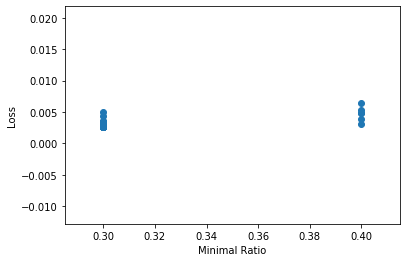

In [47]:
plt.scatter(min_ratio_list2,grads_loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')